# Benchmarking models at locating spatial expression of cell types with scRNA-seq reference and Visium spatial (mouse brain)

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
import pymc3 as pm
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

import cell2location.models as c2l
import cell2location.plt as c2lpl
import cell2location.cluster_averages 
import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
import itertools

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

### The purpose of the notebook is to benchmark several versions of the model using mouse brain data.

In [2]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_snrna/'
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/data/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/'

In [3]:
# extract 2 selected samples
adata_snrna_raw = anndata.read(f'{sc_data_folder}rawdata/all_cells_20200625.h5ad')
adata_snrna_raw = adata_snrna_raw[adata_snrna_raw.obs['sample'].isin(['5705STDY8058280', '5705STDY8058281']), :]

## Cell type annotations
labels = pd.read_csv(f'{sc_data_folder}snRNA_annotation_astro_subtypes_refined59_20200823.csv', index_col=0)
labels = labels.reindex(index=adata_snrna_raw.obs_names)
adata_snrna_raw.obs[labels.columns] = labels
adata_snrna_raw = adata_snrna_raw[~adata_snrna_raw.obs['annotation_1'].isna(), :]
ct_sel = adata_snrna_raw.obs['annotation_1'].value_counts() > 40
ct_sel = list(np.array(ct_sel.index)[ct_sel.values])
adata_snrna_raw = adata_snrna_raw[adata_snrna_raw.obs['annotation_1'].isin(ct_sel), :]

adata_snrna_raw.write(f'{sc_data_folder}rawdata/5705STDY8058280_5705STDY8058281_20210129.h5ad')

shared_names = adata_snrna_raw.obs_names[adata_snrna_raw.obs_names.isin(labels.index)]
labels = labels.loc[shared_names,]
labels.to_csv('/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/snRNA_annotation_subclusters_20210129_samples2.csv')

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
... storing 'annotation_1' as categorical


In [4]:
adata_snrna_raw.obs['annotation_1'].value_counts()

Oligo_2           4021
Ext_L23            715
Ext_Thal_1         546
Inh_4              537
Ext_L25            520
Ext_L56            514
Micro              505
Ext_Pir            489
Inh_1              477
Ext_Hpc_DG2        475
Ext_L5_1           432
Unk_1              375
OPC_1              372
Inh_Pvalb          362
Ext_Hpc_CA1        341
Inh_Meis2_3        323
Ext_Thal_2         316
Ext_Amy_2          313
Inh_3              288
Inh_Sst            250
Inh_6              244
Inh_Meis2_2        242
Ext_L6             240
Inh_Vip            215
Astro_CTX          208
Ext_Hpc_DG1        202
Inh_Meis2_1        181
Astro_HYPO         179
Oligo_1            179
Astro_AMY_CTX      168
Inh_2              151
Astro_THAL_med     149
Inh_Lamp5          135
Astro_AMY          125
Astro_THAL_lat     123
OPC_2              120
Ext_Hpc_CA3        120
Ext_L6B            119
LowQ_2             119
Ext_Amy_1          106
Ext_L5_2           105
Nb_1               105
Astro_HPC          101
Ext_ClauPyr

In [5]:
## Generate generation - training split (to reflect that spatial data does not have exactly the same cells)
from sklearn.model_selection import train_test_split
idx = np.arange(len(adata_snrna_raw))
train_idx, val_idx = train_test_split(idx, train_size=0.5,
                                      shuffle=True, stratify=adata_snrna_raw.obs['annotation_1'])

adata_snrna_raw[train_idx].write(f'{sp_data_folder}generation_5705STDY8058280_5705STDY8058281_20210129.h5ad')
adata_snrna_raw[val_idx].write(f'{sp_data_folder}training_5705STDY8058280_5705STDY8058281_20210129.h5ad')

adata_snrna_raw[train_idx].obs['annotation_1'].value_counts(), adata_snrna_raw[train_idx].obs['annotation_1'].value_counts().shape

(Oligo_2           2010
 Ext_L23            357
 Ext_Thal_1         273
 Inh_4              268
 Ext_L25            260
 Ext_L56            257
 Micro              252
 Ext_Pir            244
 Inh_1              238
 Ext_Hpc_DG2        237
 Ext_L5_1           216
 Unk_1              187
 OPC_1              186
 Inh_Pvalb          181
 Ext_Hpc_CA1        170
 Inh_Meis2_3        161
 Ext_Thal_2         158
 Ext_Amy_2          156
 Inh_3              144
 Inh_Sst            125
 Inh_6              122
 Inh_Meis2_2        121
 Ext_L6             120
 Inh_Vip            107
 Astro_CTX          104
 Ext_Hpc_DG1        101
 Inh_Meis2_1         90
 Astro_HYPO          90
 Oligo_1             90
 Astro_AMY_CTX       84
 Inh_2               76
 Astro_THAL_med      75
 Inh_Lamp5           68
 Astro_AMY           63
 Astro_THAL_lat      62
 OPC_2               60
 Ext_Hpc_CA3         60
 Ext_L6B             60
 LowQ_2              60
 Ext_L5_2            53
 Ext_Amy_1           53
 Nb_1           

In [6]:
## generate per cell type simulation attributes
np.random.seed(223)
n_locations = 2000
n_cell_types = adata_snrna_raw[train_idx].obs['annotation_1'].value_counts().shape[0]

# sparsity and tissue zones
n_tissue_zones = 12
n_uniform = 8
n_sparse = n_cell_types - n_uniform
n_zones_per_cell_type = np.random.binomial(n_tissue_zones, 0.02, size=n_sparse)+1

# low and high density cell types
p_high_density = 0.2
mu_low_density = 1.5
mu_high_density = 3.2

cell_types = np.array(adata_snrna_raw[train_idx].obs['annotation_1'].unique())
uniform_cell_types = np.random.choice(cell_types, n_uniform, replace=False)
sparse_cell_types = cell_types[~np.isin(cell_types, uniform_cell_types)]

# generate matrix of which cell types are in which zones
cell_types2zones = pd.DataFrame(0, index=cell_types, 
                                columns=[f'tissue_zone_{i}' for i in range(n_tissue_zones)] \
                                + [f'uniform_{i}' for i in range(n_uniform)])
for i, n in enumerate(n_zones_per_cell_type):
    pos = np.random.randint(n_tissue_zones, size=n)
    cell_types2zones.iloc[i,pos] = 1
    
# and which uniform cell types belong to which uniform pattern
for i in range(n_uniform):
    cell_types2zones.iloc[n_sparse+i, n_tissue_zones+i] = 1
    
cell_types2zones.sum(), cell_types2zones.sum(1)

(tissue_zone_0     6
 tissue_zone_1     5
 tissue_zone_2     4
 tissue_zone_3     6
 tissue_zone_4     8
 tissue_zone_5     2
 tissue_zone_6     3
 tissue_zone_7     3
 tissue_zone_8     3
 tissue_zone_9     5
 tissue_zone_10    5
 tissue_zone_11    2
 uniform_0         1
 uniform_1         1
 uniform_2         1
 uniform_3         1
 uniform_4         1
 uniform_5         1
 uniform_6         1
 uniform_7         1
 dtype: int64,
 OPC_2             2
 Astro_HPC         2
 Oligo_2           2
 Inh_1             1
 Astro_THAL_lat    1
 Ext_Hpc_DG2       2
 Inh_2             1
 Astro_CTX         2
 Unk_1             2
 Ext_Thal_1        2
 Ext_Pir           1
 Ext_L23           1
 Inh_Vip           1
 Ext_Hpc_DG1       1
 Ext_L5_1          1
 Micro             2
 Ext_Hpc_CA1       1
 Ext_L25           2
 Ext_L56           1
 OPC_1             2
 Inh_Pvalb         1
 Inh_Meis2_4       1
 Inh_4             1
 Inh_3             1
 Inh_Lamp5         1
 Astro_AMY_CTX     1
 Nb_1              

In [7]:
np.random.seed(223)
# Assign cell types to either high or low density, balanced by uniform / tissue zone
high_density_cell_types = list(np.random.choice(uniform_cell_types, 
                                                int(np.round(n_uniform * p_high_density)), 
                                                replace=False))
for z, n in cell_types2zones.sum().items():
    
    ct = list(np.random.choice(cell_types2zones.index[cell_types2zones[z] > 0], 
                                                int(np.round(n * p_high_density)), 
                                                replace=False))
    print(ct)
    high_density_cell_types = high_density_cell_types + ct
    
low_density_cell_types = cell_types[~np.isin(cell_types, high_density_cell_types)]
    
# what proportion of cells are uniform?
len(high_density_cell_types) / len(cell_types)

['Inh_Meis2_4']
['Inh_Meis2_2']
['Nb_1']
['Ext_Thal_2']
['Ext_L6B', 'Ext_Thal_1']
[]
['Inh_Sst']
['Astro_HPC']
['Micro']
['Astro_THAL_med']
['OPC_1']
[]
[]
[]
[]
[]
[]
[]
[]
[]


0.2653061224489796

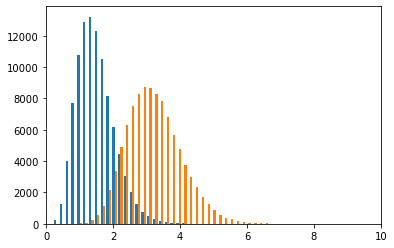

In [8]:
np.random.seed(223)
#Generate average abundance for low and high density cell types
mean_var_ratio = 5
plt.hist([np.random.gamma(mu_low_density * mean_var_ratio, 1/mean_var_ratio, size=int(1e5)),
          np.random.gamma(mu_high_density * mean_var_ratio, 1/mean_var_ratio, size=int(1e5))], bins=50);
plt.xlim(0, 10);

cell_types2zones.loc[low_density_cell_types] = cell_types2zones.loc[low_density_cell_types] \
 * np.random.gamma(mu_low_density * mean_var_ratio, 
                   1/mean_var_ratio, 
                   size=(len(low_density_cell_types), 1))

cell_types2zones.loc[high_density_cell_types] = cell_types2zones.loc[high_density_cell_types] \
 * np.random.gamma(mu_high_density * mean_var_ratio, 
                   1/mean_var_ratio, 
                   size=(len(high_density_cell_types), 1))

In [9]:
cell_types2zones

,tissue_zone_0,tissue_zone_1,tissue_zone_2,tissue_zone_3,tissue_zone_4,tissue_zone_5,tissue_zone_6,tissue_zone_7,tissue_zone_8,tissue_zone_9,tissue_zone_10,tissue_zone_11,uniform_0,uniform_1,uniform_2,uniform_3,uniform_4,uniform_5,uniform_6,uniform_7
OPC_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.801364,0.000000,0.000000,1.801364,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Astro_HPC,1.924379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.924379,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Oligo_2,0.000000,0.396190,0.000000,0.396190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Inh_1,0.000000,0.000000,0.000000,0.000000,0.000000,1.241734,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Astro_THAL_lat,0.000000,0.000000,0.000000,0.000000,1.243017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ext_Hpc_DG2,1.656260,0.000000,0.000000,0.000000,1.656260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Inh_2,0.000000,0.000000,0.000000,0.000000,0.000000,1.732860,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Astro_CTX,1.022652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.022652,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Unk_1,0.000000,0.000000,1.682711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.682711,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ext_Thal_1,0.000000,0.000000,0.000000,2.328518,2.328518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


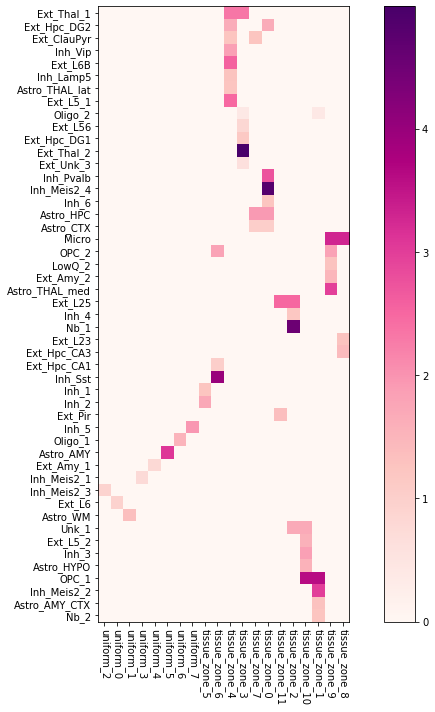

In [10]:
from cell2location.plt.plot_heatmap import clustermap
clustermap(cell_types2zones, figure_size=[10, 10])

## Generate spatial patterns (uniform_i & per tissue_zone_i)

In [11]:
def kernel(X1, X2, l=1.0, eta=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return eta**2 * np.exp(-0.5 / l**2 * sqdist)
    
    
    np.random.seed(192)

def random_GP(n_cell_types = 5, #zones
              n=[50, 50], #spatial dimensions 
              eta_true = 5, #variance, defines overlapping
              l1_true=[8, 10, 15], #bw parameter
              l2_true=[8, 10, 15]
             ):
    n1, n2 = n 
    x1 = np.linspace(0, 100, n1)[:,None] #saptial dimensions 
    x2 = np.linspace(0, 100, n2)[:,None] #saptial dimensions 

    # make cartesian grid out of each dimension x1 and x2
    X = pm.math.cartesian(x1[:,None], x2[:,None])

    l2_true = l1_true

    #cov1, cov2 = kernel(x1, x1, l=l1_true), kernel(x2, x2, l=l2_true)
    K = [np.kron(kernel(x1, x1, l=l1_true[i], eta=eta_true), 
                 kernel(x2, x2, l=l2_true[i], eta=eta_true)) 
         for i in range(n_cell_types)]

    gaus_true = np.stack([np.random.multivariate_normal(np.zeros(X.shape[0]), 
                                                        2*K[i]) 
                          for i in range(n_cell_types)]).T #samples from GP
    N_true = (np.exp(gaus_true).T / np.exp(gaus_true).sum(axis=1)).T #softmax transform 
    return N_true, X


def plot_spatial(values, n=[50,50], nrows=5, names=['cell type'],
                 vmin=0, vmax=1):
    
    n_cell_types = values.shape[1]
    n1, n2 = n 
    ncols = np.ceil((n_cell_types+1) / nrows)
    for ct in range(n_cell_types):
        plt.subplot(nrows, ncols, ct+1)
        plt.imshow(values[:,ct].reshape(n1,n2).T, 
                   cmap=plt.cm.get_cmap('magma'),
                   vmin=vmin, vmax=vmax
                  )
        plt.colorbar()
        if len(names) > 1:
            plt.title(names[ct])
        else:
            plt.title(f'{names[0]} {ct+1}')

    plt.subplot(nrows, ncols, n_cell_types+1) 
    plt.imshow(values.sum(axis=1).reshape(n1,n2).T, 
               cmap=plt.cm.get_cmap('Greys'))
    plt.colorbar()
    plt.title('total')

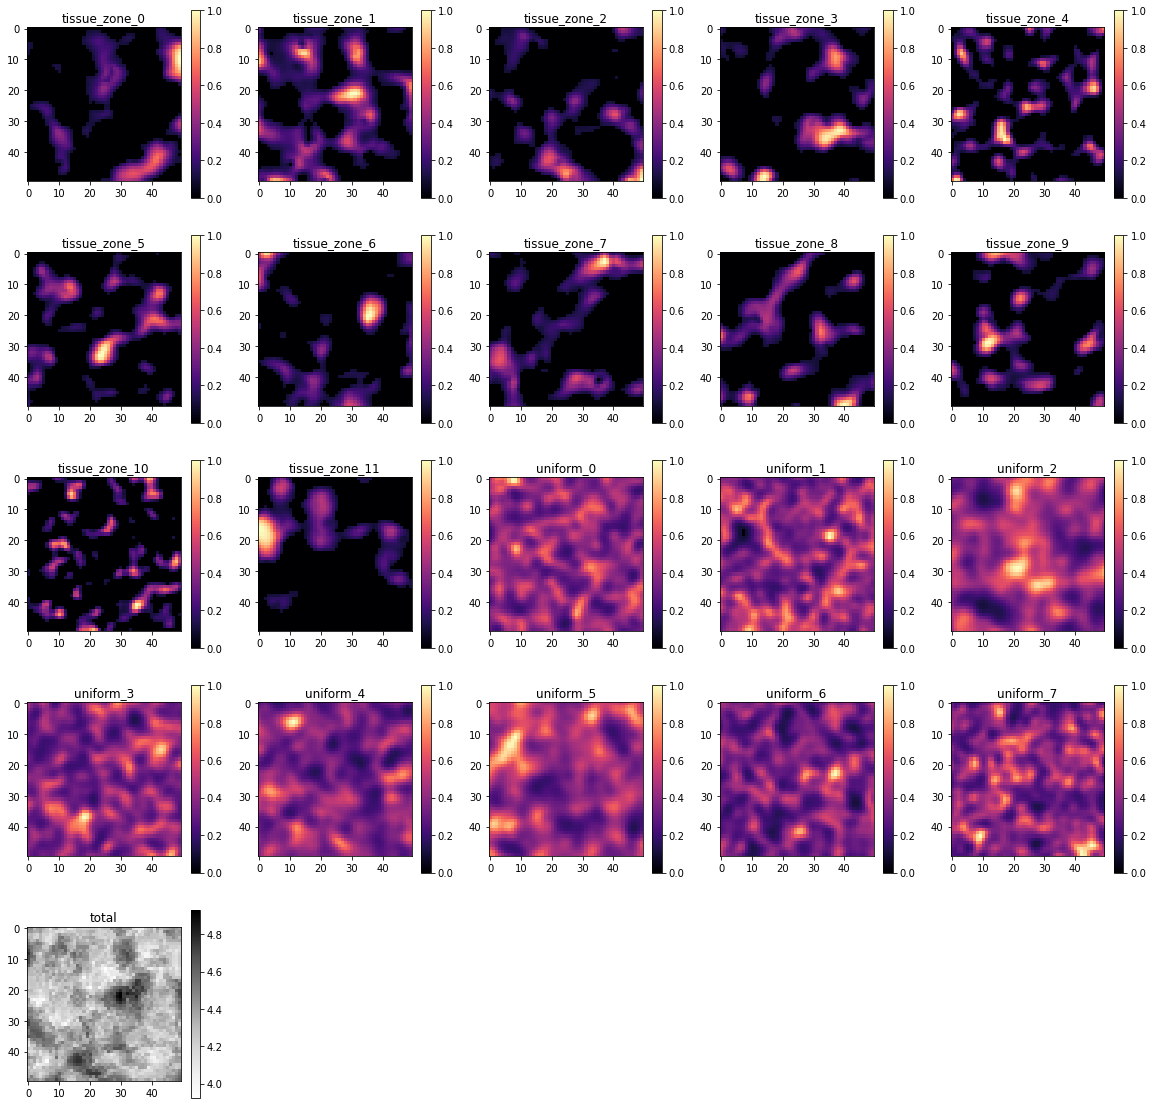

In [12]:
np.random.seed(223)
# Sample bw parameter
mean_var_ratio = 1.2
mean = 8
tissue_zones_l1_true = np.random.gamma(mean * mean_var_ratio, 1 / mean_var_ratio, 
                                       size=(n_tissue_zones))
uniform_cell_types_l1_true = np.random.gamma(mean * mean_var_ratio, 1 / mean_var_ratio, 
                                             size=(len(uniform_cell_types)))

# Sample abundances with GP
sparse_abundances, sparse_locations = random_GP(n_cell_types=n_tissue_zones, 
                                                n=[50, 50], eta_true=1,
                                                l1_true=tissue_zones_l1_true,
                                                l2_true=tissue_zones_l1_true)
sparse_abundances = sparse_abundances / sparse_abundances.max(0)
sparse_abundances[sparse_abundances < 0.1] = 0

uniform_abundances, uniform_locations = random_GP(n_cell_types=len(uniform_cell_types), 
                                                  n=[50, 50], eta_true=0.5,
                                                l1_true=uniform_cell_types_l1_true,
                                                l2_true=uniform_cell_types_l1_true)
uniform_abundances = uniform_abundances / uniform_abundances.max(0)
uniform_abundances[uniform_abundances < 0.1] = 0

abundances = np.concatenate([sparse_abundances, uniform_abundances], axis=1)
abundances_df = pd.DataFrame(abundances, 
                             index=[f'location_{i}' for i in range(abundances.shape[0])],
                             columns=cell_types2zones.columns
                            )

plt.figure(figsize=(3*5+5,3*5+5))
plot_spatial(abundances_df.values, n=[50,50], nrows=5, names=abundances_df.columns)

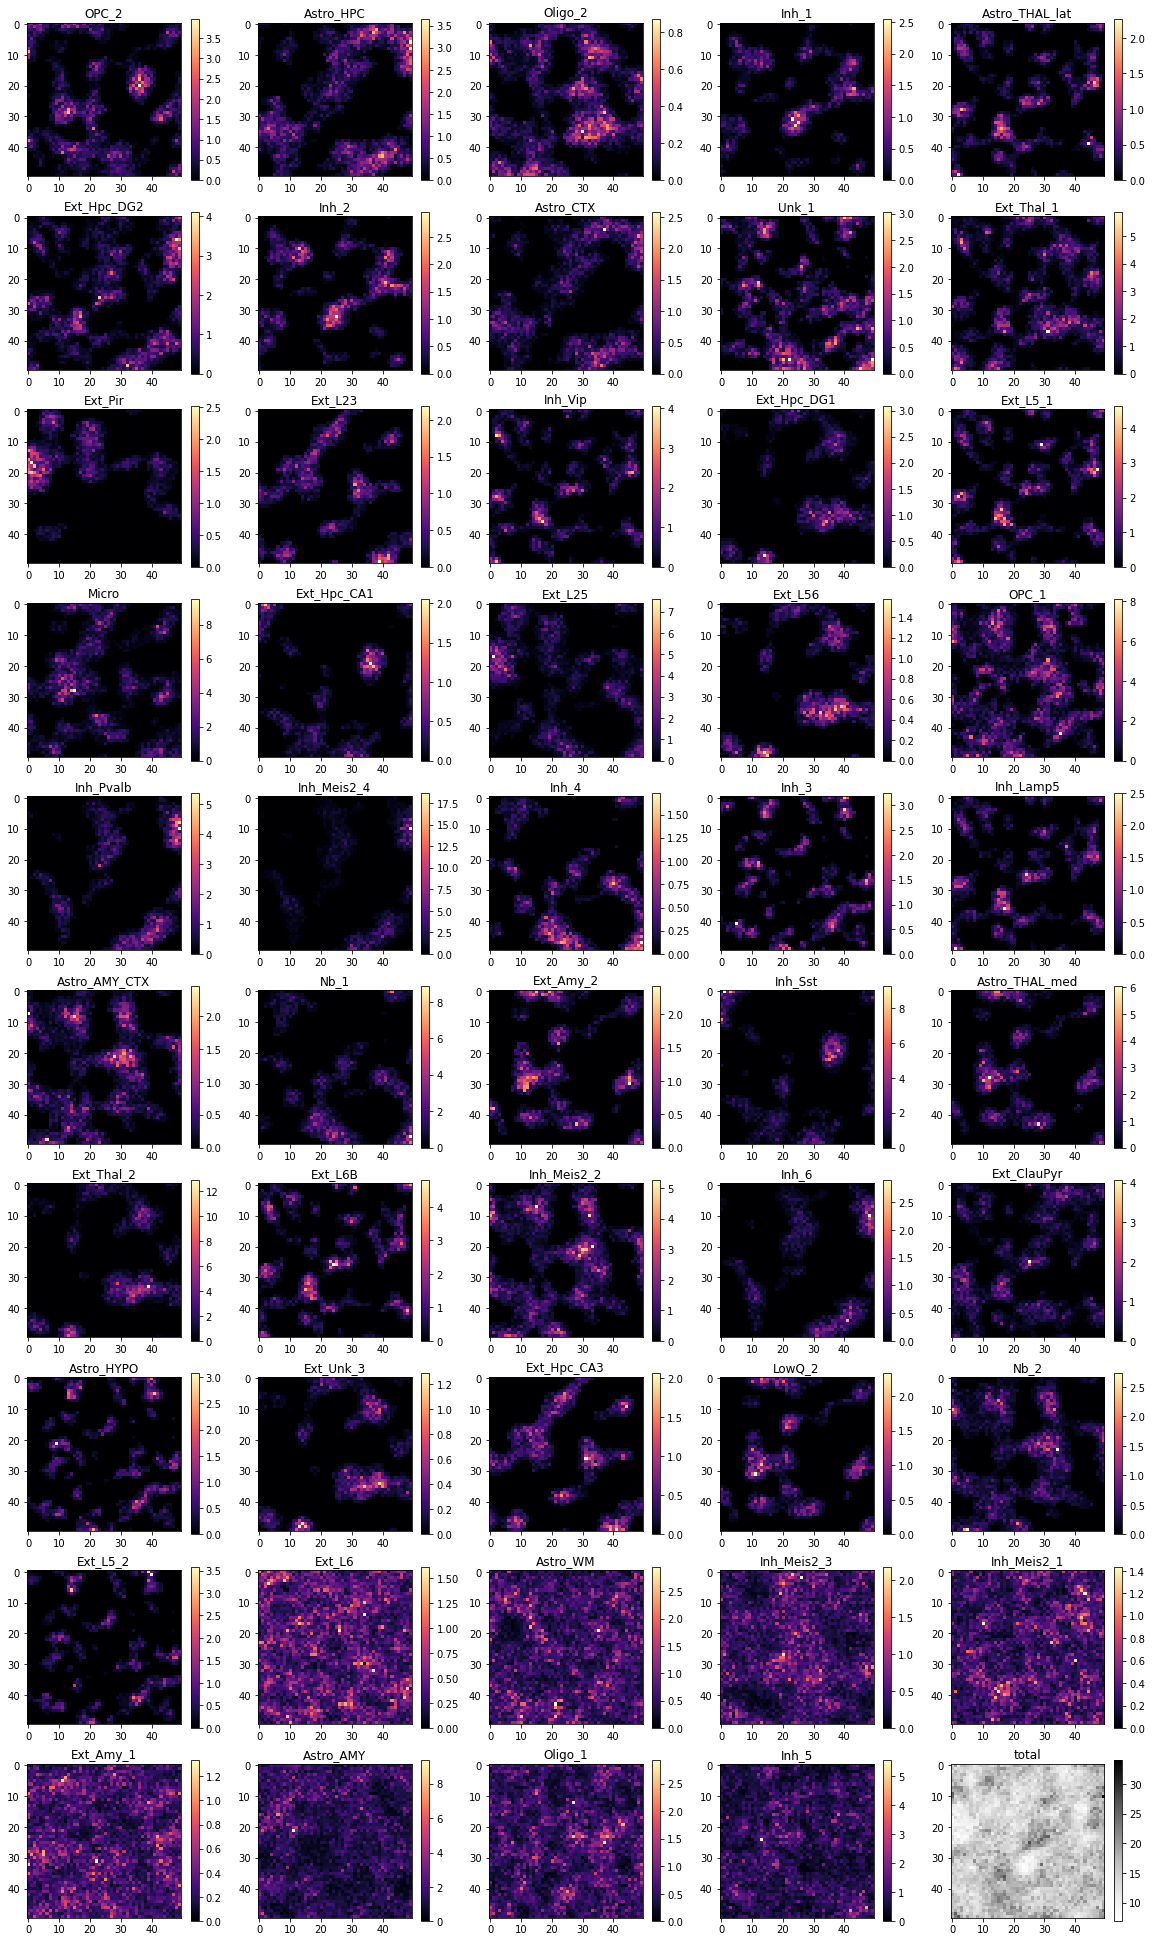

In [13]:
np.random.seed(223)
cell_abundances = np.dot(abundances_df, cell_types2zones.T)
cell_abundances = cell_abundances * np.random.lognormal(0, 0.4, size=cell_abundances.shape)
cell_abundances_df = pd.DataFrame(cell_abundances, 
                             index=abundances_df.index,
                             columns=cell_types2zones.index
                            )

plt.figure(figsize=(3*5+5, 3*10+5))
plot_spatial(cell_abundances_df.values, n=[50,50], nrows=10, 
             names=cell_abundances_df.columns, vmax=None)

0.8331299045616771

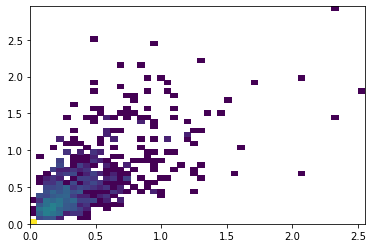

In [20]:
plt.hist2d(cell_abundances_df['Inh_1'].values, 
           cell_abundances_df['Inh_2'].values,
           bins=50, norm=matplotlib.colors.LogNorm());
np.corrcoef(cell_abundances_df['Inh_1'].values, 
           cell_abundances_df['Inh_2'].values)[0,1]

### Make cell abundance discrete

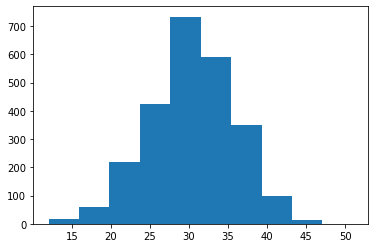

OPC_2             1504.0
Astro_HPC         1636.0
Oligo_2           1721.0
Inh_1              863.0
Astro_THAL_lat     990.0
Ext_Hpc_DG2       1708.0
Inh_2              910.0
Astro_CTX         1401.0
Unk_1             1532.0
Ext_Thal_1        2024.0
Ext_Pir            780.0
Ext_L23            855.0
Inh_Vip           1091.0
Ext_Hpc_DG1        832.0
Ext_L5_1          1196.0
Micro             2292.0
Ext_Hpc_CA1        699.0
Ext_L25           1775.0
Ext_L56            800.0
OPC_1             3310.0
Inh_Pvalb          999.0
Inh_Meis2_4       1434.0
Inh_4              814.0
Inh_3              885.0
Inh_Lamp5          992.0
Astro_AMY_CTX     1545.0
Nb_1              1265.0
Ext_Amy_2          882.0
Inh_Sst           1069.0
Astro_THAL_med    1156.0
Ext_Thal_2        1677.0
Ext_L6B           1206.0
Inh_Meis2_2       1991.0
Inh_6              802.0
Ext_ClauPyr       1560.0
Astro_HYPO         838.0
Ext_Unk_3          792.0
Ext_Hpc_CA3        869.0
LowQ_2             854.0
Nb_2              1527.0


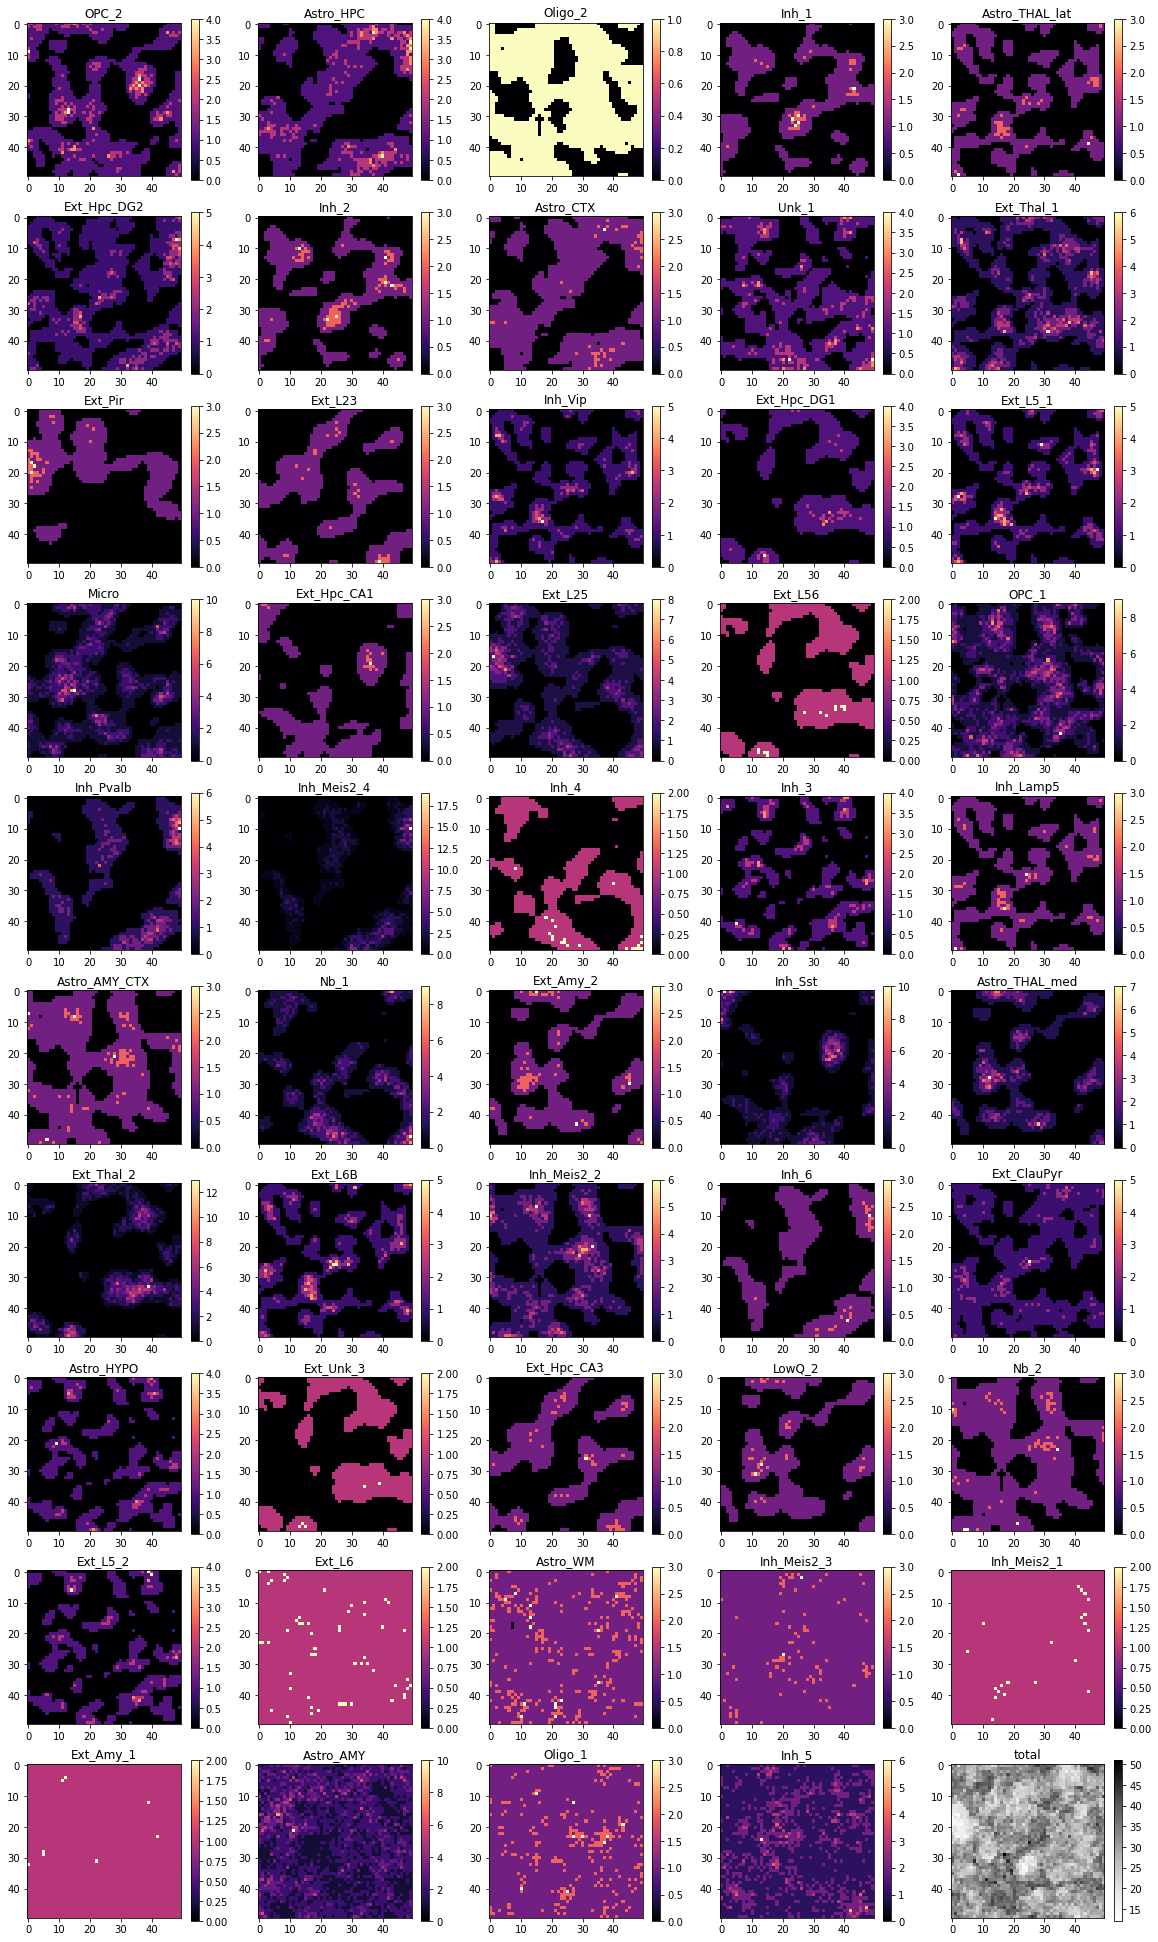

In [15]:
cell_count_df = np.ceil(cell_abundances_df)
plt.hist(cell_count_df.sum(1));
plt.show();

plt.figure(figsize=(3*5+5, 3*10+5))
plot_spatial(cell_count_df.values, n=[50,50], nrows=10, 
             names=cell_count_df.columns, vmax=None)

cell_count_df.sum(0)

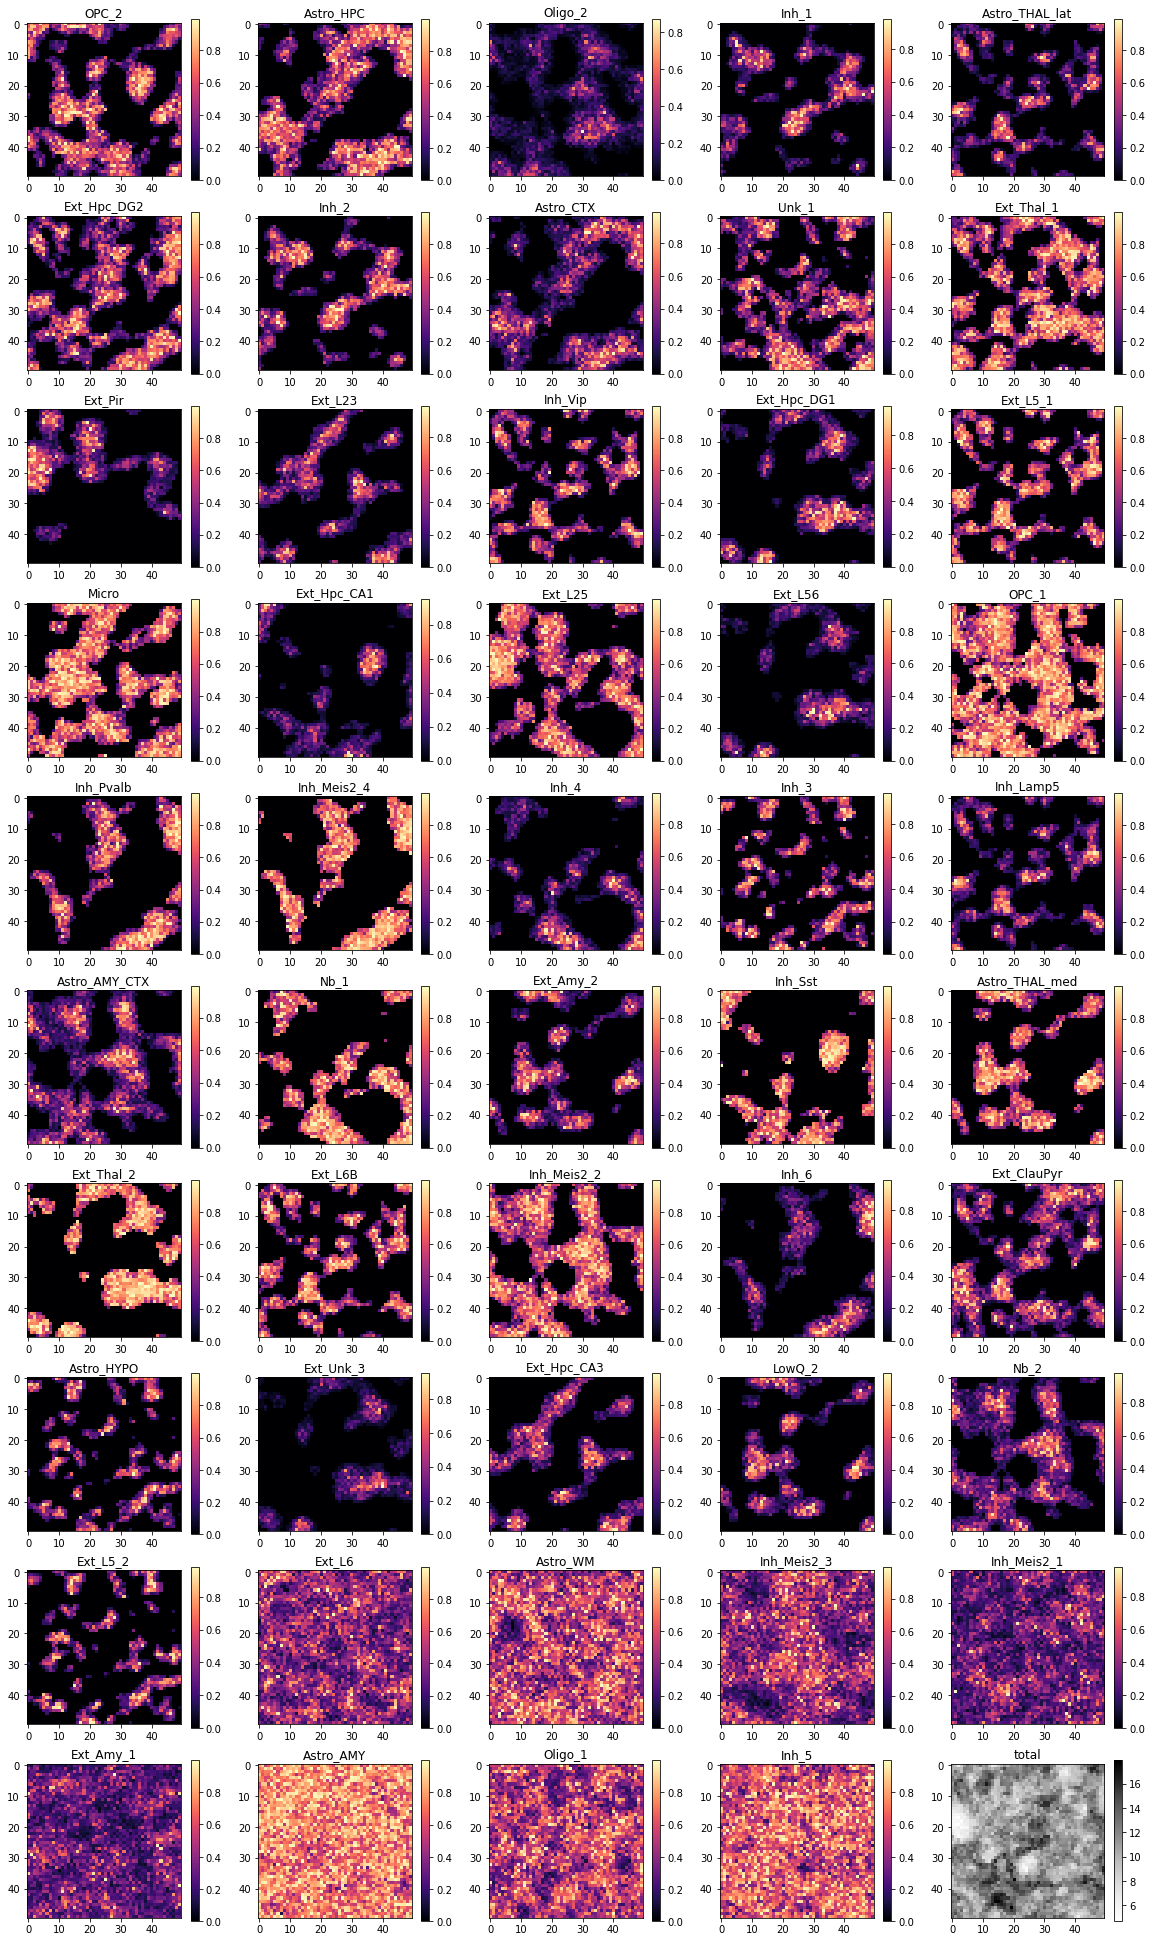

In [16]:
cell_capture_eff_df = cell_abundances_df / cell_count_df
cell_capture_eff_df[cell_capture_eff_df.isna()] = 0

plt.figure(figsize=(3*5+5, 3*10+5))
plot_spatial(cell_capture_eff_df.values, n=[50,50], nrows=10, 
             names=cell_capture_eff_df.columns, vmax=None)

### Save resulting w_sf matrices

In [17]:
cell_count_df.to_csv(f'{sp_data_folder}cell_count_df_20210129.csv')
cell_capture_eff_df.to_csv(f'{sp_data_folder}cell_capture_eff_df_20210129.csv')
cell_abundances_df.to_csv(f'{sp_data_folder}cell_abundances_df_20210129.csv')

### Sample cell indices

In [18]:
np.random.seed(223)

from scipy.sparse import csr_matrix

# create generation set
generation_snrna = adata_snrna_raw[train_idx].copy()
# add index to each cell
generation_snrna.obs['cell_ind'] = np.arange(generation_snrna.shape[0])

locations2cells = np.zeros((cell_count_df.shape[0], generation_snrna.shape[0]))
for i, l in enumerate(cell_count_df.index):
    for j, ct in enumerate(cell_count_df.columns):
        cell_ind_all = generation_snrna.obs['cell_ind']
        cell_ind_all = cell_ind_all[generation_snrna.obs['annotation_1'] == ct]
        cell_ind = np.random.choice(cell_ind_all, int(cell_count_df.loc[l, ct]), replace=False)
        locations2cells[i,cell_ind] = cell_capture_eff_df.loc[l, ct]
        
locations2cells = csr_matrix(locations2cells)

### Construct mRNA counts, rescale sensitivity, add noise

In [21]:
# Compute synthetic counts
synthetic_counts = locations2cells.dot(generation_snrna.X)

# Create adata object
synth_adata = anndata.AnnData(synthetic_counts)
synth_adata.obs_names = cell_count_df.index
synth_adata.var_names = generation_snrna.var_names
synth_adata.obs[[f'cell_count_{ct}' for ct in cell_count_df.columns]] = cell_count_df
synth_adata.obs[[f'cell_abundances_{ct}' for ct in cell_abundances_df.columns]] = cell_abundances_df
synth_adata.obs[[f'cell_capture_eff_{ct}' for ct in cell_capture_eff_df.columns]] = cell_capture_eff_df
synth_adata.obsm['X_spatial'] = sparse_locations

synth_adata.shape

(2500, 31053)

0.24957359439394033

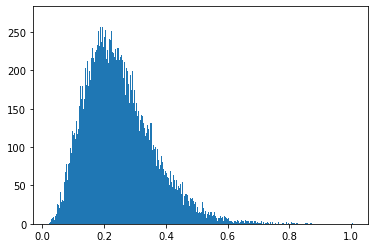

In [22]:
np.random.seed(223)
# Sample detection rates
gene_level = np.random.gamma(shape=5, scale=1/20, size=(1, synth_adata.shape[1]))
plt.hist(gene_level.flatten(), bins=500);

synth_adata.var['gene_level'] = gene_level.flatten()
synth_adata.X = synth_adata.X.toarray() * gene_level

# Sample poisson integers
synth_adata.X = np.random.poisson(synth_adata.X)
synth_adata.X = csr_matrix(synth_adata.X)
gene_level.mean()

In [23]:
# save resulting anndata
synth_adata.write(f'{sp_data_folder}synth_adata_20210129.h5ad')

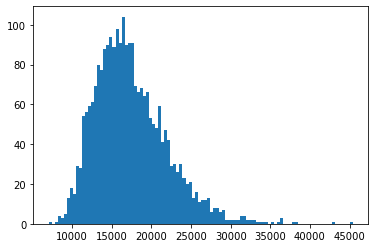

In [24]:
plt.hist(np.array(synth_adata.X.sum(1)).flatten(), bins=100);